### Importing necessary files

In [ ]:
!pip install monai

In [1]:
cd C:\Users\ASIVAKUM\Desktop\monai_utils\

C:\Users\ASIVAKUM\Desktop\monai_utils


In [343]:
!pip install rising

In [ ]:
os.chdir( "C:/Users/ASIVAKUM/Desktop/monai_utils/")  #change directory to downloaded utility files

!pip install monai-0.6.0-202107081903-py3-none-any.whl


In [7]:
!pip install pydicom

In [ ]:
#!pip3 install albumentations
!pip3 install --upgrade albumentations --user

In [ ]:
!pip install -U albumentations

In [ ]:
!pip3 install  imgaug
!pip3 install  albumentations

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
from IPython.display import clear_output

from PIL import Image as im
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import glob
import cv2

import torch.optim as optimizers
import torch.optim.lr_scheduler as schedulers
from torch.utils.data import Dataset

In [3]:
from monai.transforms import (
    EnsureChannelFirst,
    Compose,
    RandRotate90,
    Resize,
    ScaleIntensity,
)

In [4]:
import albumentations as A
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import roc_auc_score
from torch.optim import lr_scheduler
from tqdm import tqdm
import re
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2

### Setting necessary parameters

In [66]:
NUM_IMAGES_3D = 64
TRAINING_BATCH_SIZE = 8
TEST_BATCH_SIZE = 8
IMAGE_SIZE = 256
N_EPOCHS = 15
do_valid = True
n_workers = 4


#### Note: same helper functions are used for 2d CNN, check out comments in 2D cnn notebook for more detailed description

In [67]:
def compute_precision(output, target, topk=(1, ), return_preds=False):
    """Computes the precision@k for the specified values of k"""
    topk_orig = topk
    topk = [k for k in topk if k <= output.size(1)]
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    label_preds = pred[:, 0]
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100. / batch_size))
    res.extend(100 for k in topk_orig if k > output.size(1))
    if return_preds:
        return res, label_preds
    return res

In [72]:

def load_dicom_image(path, img_size=256, voi_lut=True, rotate=0,transform = None):
    """
    Load dicom images present in the directory
    :param path: path to file
    :img_size: resizes images to given size
    :voi_lut: if True gets 3D MRI images
    :rotate: if rotation needs to be done
    :img_type: if image type is dicom load pixel array or if annotated slices load using pickle
    """ 
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
        
        if transform=='default':
            data = cv2.normalize(data, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)         
            data = cv2.resize(data,(img_size, img_size)) 
            
            
        else:
            data = cv2.resize(data, (img_size, img_size))
    else:
        data = dicom.pixel_array
        data = cv2.resize(data, (img_size, img_size))
    
    
    
    return data

In [73]:
def init_scheduler(scheduler_config, optimizer):  # *
    
        scheduler_class = getattr(schedulers, scheduler_config['class_name'])
        return scheduler_class(optimizer, **scheduler_config['class_args'])

In [74]:
def evaluate_confusion_matrix(dataloader,model,verbose=False,device = torch.device("cuda")):
    """
    Evaluate the model's accuracy 
    :param dataloader: The dataloader for the validation/testing data
    :param model: The model to evaluate
    :param verbose: Whether to print the results
    :device: shows which device to use
    :return: Accuracy ,Sensitivity, Specificity and confusion matrix of model
    """
    total_acc_val =0
    model.eval()
    preds =[]
    labels = []
    with torch.no_grad():
        for test_input,label in dataloader:
            test_input, label = test_input.to(device), label.to(device)
            model.eval()
            
            outputs = model(test_input)
            y_hat = F.softmax(outputs)
            acc = (outputs.argmax(dim=1) == label ).sum().item()
            total_acc_val += acc
            _, pred = outputs.max(1)
            
            preds.append(y_hat)
            labels.append(label.numpy() )
            if verbose:
                print("model predictions",pred,"/",label)
            import gc
            gc.collect()
        accuracy = total_acc_val/len(test_csv)       
        cm = confusion_matrix(label,pred)
        ax= plt.subplot()
        sns.heatmap(cm, annot=True, fmt='g', ax=ax);  

        # labels, title and ticks
        ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
        ax.set_title('Confusion Matrix'); 


        class_report = metrics.classification_report(y_true = label, y_pred =pred, output_dict=True)

        print("Sensitivity %.4f"%(class_report['1']['recall']))

        print("Specificity %.4f"%(class_report['0']['recall']))

        print("Precision %.4f"%(class_report['1']['precision']))

        print("False Positive Rate %.4f"%(1-class_report['0']['recall']))

        print("F1-score %.4f"%(class_report['1']['f1-score']))
        if verbose:
            print("accuracy of model",accuracy)
        return accuracy

In [75]:
def evaluate(dataloader,model,verbose=False):
    total_acc_val =0
    model.eval()
    with torch.no_grad():
        for test_input,label in dataloader:
            model.eval()
            
            outputs = model(test_input)
            y_hat = F.softmax(outputs)
            acc = (outputs.argmax(dim=1) == label ).sum().item()
            total_acc_val += acc
            _, pred = outputs.max(1)
            if verbose:
                print("model predictions",pred,"/",label)
            import gc
            gc.collect()
        accuracy = total_acc_val/len(test_csv)       
        
        if verbose:
            print("accuracy of model",accuracy)
        return accuracy
        
        

In [76]:
def get_train_splits(file=None,val_prop=0.10,test_prop=0.2):
    
    ''' Randomizes the train-validation-Test instances with fixed proportion'''
    
    
        
    df_splits = file
    df_splits.reset_index(inplace=True,drop = True)

    prop = test_prop

    df1 = df_splits[df_splits['Neoadjuvant therapy'] == 1 ]
    df2 = df_splits[df_splits['Neoadjuvant therapy'] == 2 ]

    print(len(df1))
    print(len(df2))

    df_sample = df1.sample(frac=1)
    t_size1 = int(test_prop* len(df_sample))
   

    df_split1_1 = df_sample[:t_size1]
    df_split1_2 = df_sample[t_size1:]


    df_sample2 = df2.sample(frac=1)
    t_size2 = int(test_prop* len(df_sample2))
    
    
    df_split2_1 = df_sample2[:t_size2]
    df_split2_2 = df_sample2[t_size2:]


    df_split_test = pd.concat([df_split2_1,df_split1_1], axis=0)    
    df_split_train = pd.concat([df_split1_2, df_split2_2], axis=0)

    
    df_split_train.reset_index(inplace=True,drop=True)
    df_split_test.reset_index(inplace=True,drop=True)
    
    return df_split_train,df_split_test

In [77]:

def get_sampler_weights(subclass_labels):
    
    subclasses = torch.unique(subclass_labels)
    
    subclass_freqs = []

    for subclass in subclasses:
        subclass_counts = sum(subclass_labels == subclass)
        subclass_freqs.append(1 / subclass_counts)

    subclass_weights = torch.zeros_like(subclass_labels).float()
    

    for idx, label in enumerate(subclass_labels):
            if idx ==0:
                pass
            else:
                
                subclass_weights[idx] = subclass_freqs[int(label)]

    return subclass_weights

In [78]:
def train_3dnet(params,trainDataloader,test_dataloader,model,epochs=2):

    max_val_acc = -1
    perfect_epoch = 0
    max_val_acc = 0
    
    criterion = nn.CrossEntropyLoss()
    
    if params['opt'] =='Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr =params['learning_rate']) 
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr =params['learning_rate'],weight_decay =params['w_d']) 
        
    if params['scheduler_choice'] == 1:
        scheduler = init_scheduler({'class_args': {'patience':params['patience'],'factor': params['factor'],'mode':'max'},'class_name': 'ReduceLROnPlateau'},optimizer)   
    else:
        scheduler = None
    EPOCHS=epochs
    device = torch.device("cpu")
    
    model.train()
    for epoch in range(EPOCHS):
        for  train_input,train_label in trainDataloader:


            train_label = train_label.to(device)
            train_input = train_input.to(device)


            optimizer.zero_grad()
            output = model(train_input)

            _, predictions = output.max(1)
            
            loss = criterion(output,train_label)
            batch_loss =loss


            print(batch_loss)

            model.zero_grad()

            batch_loss.backward()
            optimizer.step()
    
        model.eval()
        cur_model = model 
        with torch.no_grad():
            acc = evaluate(test_dataloader,model)
            print("epoch", epoch,'\n'
                  "Validation Accuracy",acc,'\n'
                  "Best accuracy",max_val_acc)
            if acc > max_val_acc:
                perfect_epoch = epoch
                max_val_acc = acc
                model = cur_model
                old_model =  model
                torch.save(model.state_dict(), 'D:/Duke/Best_model_3dnet.pth')
                print("perfect epoch",perfect_epoch)
            else:
                try:
                    model = old_model
                except:
                    pass
            if scheduler:
                scheduler.step(acc)
    return model,max_val_acc
                
            
                   
                    
             
    

In [79]:
class Duke_Dataset(Dataset):
    def __init__(self, data, transform=None, target="Neoadjuvant therapy"):
        self.target = target
        self.data = data
        
        print(data['Neoadjuvant therapy'])
        self.labels = torch.tensor(data["Neoadjuvant therapy"].astype(int).replace(1, 0).replace(2, 1).values, device=device, dtype=torch.long)
        
        
        self.transform = transform
        self.locations = "File_Location"
        
        self.sub_id = "Subject ID"

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data.loc[index]
        case_id = str(row[self.locations])
        
        tgt = int(row[self.target])
        if tgt == 1:
            tgt =  torch.tensor(0, device=device, dtype=torch.long)
        else:
            tgt =  torch.tensor(1, device=device, dtype=torch.long)
        _3d_images = self.load_dicom_images_3d(case_id)
        _3d_images = torch.tensor(_3d_images).float()
        
        Subject_ID = str(row[self.sub_id])
        Subject_ID = int(Subject_ID[-3:])
        
        
        return   _3d_images,tgt
        

    def load_dicom_images_3d(
        self,
        case_id,
        num_imgs=NUM_IMAGES_3D,
        img_size=IMAGE_SIZE,
        rotate=0,
    ):
        
        case_id = case_id[25:]
        path = r"D:/Duke/manifest-1654812109500/Duke-Breast-Cancer-MRI/" + (case_id).replace('\\', '/')  +"/*.dcm"
        
        
        files = sorted(
            glob.glob(path),
            key=lambda var: [
                int(x) if x.isdigit() else x for x in re.findall(r"[^0-9]|[0-9]+", var)
            ],
        )
        
        middle = len(files) // 2
        num_imgs2 = num_imgs // 2
        p1 = max(0, middle - num_imgs2)
        p2 = min(len(files), middle + num_imgs2)
        
        #Use a stack of images
        img_stack = [load_dicom_image(f, rotate=rotate,transform = self.transform) for f in files[p1:p2]]
        img3d = np.stack(img_stack).T  
        if img3d.shape[-1] < num_imgs:
            n_zero = np.zeros((img_size, img_size, num_imgs - img3d.shape[-1]))
            img3d = np.concatenate((img3d, n_zero), axis=-1)

        if np.min(img3d) < np.max(img3d):
            img3d = img3d - np.min(img3d)
            img3d = img3d / np.max(img3d)

        return np.expand_dims(img3d, 0)



### Visualize an example

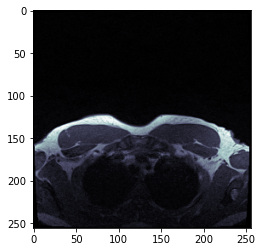

In [80]:
path = 'D:/Duke/manifest-1654812109500/Duke-Breast-Cancer-MRI/Breast_MRI_014/1.3.6.1.4.1.14519.5.2.1.255250717143362607995339673691304916086/1.3.6.1.4.1.14519.5.2.1.233574991285618950508791657379713792377/1-01.dcm'
img = load_dicom_image(path =path) 
plt.imshow(img, cmap=plt.cm.bone)  # set the color map to bone
plt.show()

In [81]:
#visualize uncropped image shape
img.shape

(256, 256)

### Loading Pre-trained Network ###

In [82]:
import monai

# model 
model = monai.networks.nets.resnet10(spatial_dims=3, n_input_channels=1, n_classes=2)
device = torch.device("cpu")
model.to(device);

criterion = nn.CrossEntropyLoss()

### Load metadata file and other necessary files

In [83]:
metadata = pd.read_csv('D:/Duke/manifest-1654812109500/metadata.csv',index_col=0)
clinic = pd.read_excel('D:/Duke/manifest-1654812109500/Clinical_and_Other_Features.xlsx',index_col=0)

clinic = clinic.drop(clinic.index[0])
clinic = clinic.drop(clinic.index[0])

clinic.reset_index(inplace=True)

clinic.rename(columns={'Patient Information': 'Subject ID'}, inplace=True)

In [84]:
metadata = metadata.merge(clinic, on='Subject ID')
metadata.rename(columns={'File Location': 'File_Location'}, inplace=True)

### Take first group of images from each patient and splitting training and testing patients

In [85]:
metadata = metadata.groupby('Subject ID').first()
metadata.drop(metadata.loc[metadata['Number of Images']==1].index, inplace=True)

In [86]:
metadata.reset_index(drop=False,inplace=True)

In [87]:
train_csv_og,test_csv_og = get_train_splits(metadata)

297
542


### Check target variable distribution

In [88]:
train_csv_og['Neoadjuvant therapy'].value_counts()

2.0    434
1.0    238
Name: Neoadjuvant therapy, dtype: int64

In [89]:

test_csv_og['Neoadjuvant therapy'].value_counts()

2.0    108
1.0     59
Name: Neoadjuvant therapy, dtype: int64

### Look at model structure

In [90]:
print(model)

ResNet(
  (conv1): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(1, 2, 2), padding=(3, 3, 3), bias=False)
  (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResNetBlock(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): ResNetBlock(
      (conv1): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine

### Train 3D Cnn model

In [91]:
train_csv_og.reset_index(drop=True,inplace=True)

In [92]:

from torchvision import transforms

#use equal, lower number of examples for each trial due to memory allocation issue.
train_csv=train_csv_og[133:343]
train_csv.reset_index(drop=True,inplace=True)
train_dataset = Duke_Dataset(data=train_csv,transform ='default')
weights = get_sampler_weights(train_dataset.labels)                                                            
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))                     
train_dl = torch.utils.data.DataLoader(train_dataset,num_workers=0, batch_size =1,sampler=sampler)

  

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
205    2.0
206    2.0
207    2.0
208    2.0
209    2.0
Name: Neoadjuvant therapy, Length: 210, dtype: float64


In [93]:
print(len(train_dataset.labels))

210


In [94]:
test_csv=test_csv_og[103:113]
test_csv.reset_index(drop=True,inplace=True)
test_dataset = Duke_Dataset(data=test_csv,transform ='default')
test_weights = get_sampler_weights(test_dataset.labels)                                                            
test_sampler = torch.utils.data.sampler.WeightedRandomSampler(test_weights, len(test_weights))   
test_dl = torch.utils.data.DataLoader(test_dataset, num_workers=0, batch_size =2, sampler=test_sampler)


0    2.0
1    2.0
2    2.0
3    2.0
4    2.0
5    1.0
6    1.0
7    1.0
8    1.0
9    1.0
Name: Neoadjuvant therapy, dtype: float64


In [95]:
test_csv['File_Location']

for i in test_csv['File_Location']:
    i = i[-3:]
    print(i)

183
346
243
957
477
624
598
314
918
259


In [96]:
params ={   'learning_rate':1e-4,
            'patience':2,
            'w_d': 0.005,
            'factor': 0.3,
            'scheduler_choice': 2,
            'opt': 'Adam' }

In [ ]:
#load downloaded pretrained weights from medical net
PATH_MODELS = 'D:/Duke/MedicalNet_pretrained_weights_23/'
PATH_PRETRAINED_WEIGHTS = os.path.join(PATH_MODELS, "resnet_10_23dataset.pth")
pretrained_model_weights = PATH_PRETRAINED_WEIGHTS

pretrain = torch.load(pretrained_model_weights)
pretrain['state_dict'] = {k.replace('module.', ''): v for k,v in pretrain['state_dict'].items()}

#set spatial dimensions to be 3 so that it accepts volumetric data
model = monai.networks.nets.resnet10(spatial_dims=3, n_input_channels=1, n_classes=2)
model.load_state_dict(pretrain['state_dict'],strict=False)

modelA,max_acc = train_3dnet(params,train_dl,test_dl, model,epochs=1)
modelA.load_state_dict(torch.load('D:/Duke/Best_model_3dnet.pth'))
clear_output()
acc = evaluate(test_dl,modelA,verbose=True)

In [40]:
acc = evaluate(test_dl,modelA,verbose=True)

C:\Users\ASIVAKUM\AppData\Local\Temp\ipykernel_13252\2237571909.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = F.softmax(outputs)


model predictions tensor([1, 1]) / tensor([1, 0])
model predictions tensor([1, 1]) / tensor([1, 1])
model predictions tensor([1, 1]) / tensor([0, 0])
model predictions tensor([0, 1]) / tensor([0, 0])
model predictions tensor([1, 1]) / tensor([1, 1])
accuracy of model 0.6


C:\Users\ASIVAKUM\AppData\Local\Temp\ipykernel_13252\3739207378.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = F.softmax(outputs)


model predictions tensor([1, 1, 0, 1, 1, 1, 1, 1, 1, 0]) / tensor([1, 0, 0, 1, 1, 1, 1, 0, 0, 0])
Sensitivity 1.0000
Specificity 0.4000
Precision 0.6250
False Positive Rate 0.6000
F1-score 0.7692
accuracy of model 0.7


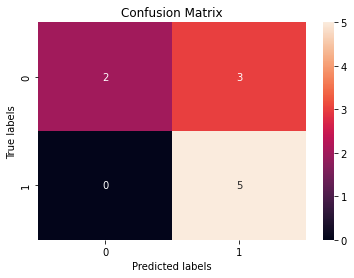

In [65]:
#visualize confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn import metrics
test_dl = torch.utils.data.DataLoader(test_dataset, num_workers=0, batch_size =10, sampler=test_sampler)
acc = evaluate_confusion_matrix(test_dl,modelA,verbose=True,device=device)